<div class='bar_title'></div>

*Simulation for Decision Making (S4DM)*

# Assignment 5: Input Modeling

Gunther Gust & Ignacio Ubeda <br>
Chair for Enterprise AI <br>
Data Driven Decisions Group <br>
Center for Artificial Intelligence and Data Science (CAIDAS)


<img src="images/d3.png" style="width:20%; float:left;" />

<img src="images/CAIDASlogo.png" style="width:20%; float:left;" />

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from matplotlib import pyplot as plt

# Agenda

* Fitting a Distribution
* Inverse Transform Method

## Scenario

You have measured customer arrivals at a store that offers food, the store opens at 6:30 in the morning and lunch is offered from 12 noon until 15:30. It is well known that peak demand occurs at lunchtime.

You record the time each customer arrives at the store and collect 100 data points (for simplicity, **assume that all customers arrive individually**). 

The resulting table is stored in `customer_arrivals.csv` and looks like the following:

In [3]:
customer_arrival_df = pd.read_csv('customer_arrivals.csv')

customer_arrival_df.head()

,timestamp
0,06:35:00
1,06:45:49
2,07:00:19
3,07:00:58
4,07:03:20


In [4]:
customer_arrival_df.tail()

,timestamp
95,14:54:40
96,14:58:13
97,15:02:36
98,15:05:41
99,15:10:39


From that, we will compute the *inter-arrival times* (**iat**) which is defined as the time between arrival of customers.

For doing so, we first create a new column `timestamp_dt` to transform the time to a datetime object. 

Then, we substract the time with the time of the previous row (`.shift(1)`) and get the total number of seconds in that timespan (`.dt.total_seconds()`).

In [5]:
#transform string to datetime (HH:MM:SS)
customer_arrival_df['timestamp_dt'] = pd.to_datetime(customer_arrival_df['timestamp'], format='%H:%M:%S')

#compute inter-arrival time (in seconds)
customer_arrival_df['iat'] = (customer_arrival_df['timestamp_dt'] - customer_arrival_df['timestamp_dt'].shift(1) ).dt.total_seconds()

print(customer_arrival_df.shape)
customer_arrival_df.head()

(100, 3)


,timestamp,timestamp_dt,iat
0,06:35:00,1900-01-01 06:35:00,NaN
1,06:45:49,1900-01-01 06:45:49,649.0
2,07:00:19,1900-01-01 07:00:19,870.0
3,07:00:58,1900-01-01 07:00:58,39.0
4,07:03:20,1900-01-01 07:03:20,142.0


Finally, we drop the first row because the **iat** is `NaN`

In [6]:
#drop na
customer_arrival_df = customer_arrival_df.dropna()

print(customer_arrival_df.shape)
customer_arrival_df.head()

(99, 3)


,timestamp,timestamp_dt,iat
1,06:45:49,1900-01-01 06:45:49,649.0
2,07:00:19,1900-01-01 07:00:19,870.0
3,07:00:58,1900-01-01 07:00:58,39.0
4,07:03:20,1900-01-01 07:03:20,142.0
5,07:07:30,1900-01-01 07:07:30,250.0


We'll use this table for the upcoming Tasks

# Exercise / Tasks

**Tasks are independently of each other.**

## Task 1:  Fitting a Distribution

We'd like to fit a probabilistic distribution to our customer arrival dataset. Recall the steps for this procedure:

1. ~~Collect data~~ (**we already did this**)
2. Summarize in a frequency distribution (histogram) to identify the shape of the distribution
3. Identify underlying theoretical probability distribution, or a family of distributions
4. Obtain parameter(s) for the chosen distribution (estimated from the data).
5. Test for fit

-----

**Task 1.1: Create a histogram (or a density plot) for the `iat` column of `customer_arrival_df` DataFrame.**

**Task 1.2: Fit and evaluate (Kolmogorov-Smirnov test) some probabilistic distributions. As a Hint, only test the distributions that are in the `list_of_potential_distributions`. Do you obtain a good fit with them?**

**Task 1.3: Plot the iat column over time. For that, you can use `sns.lineplot(x='x', y='y', data=df)` where `'x'` and `'y'` are the column names present in the `df` DataFrame. What do you see?** 

**Task 1.4: Split the dataset between non-peak and peak demand periods. Fit and evaluate (Kolmogorov-Smirnov test) some probabilistic distributions for each period (again, use only the distributions present in `list_of_potential_distributions`).** 

**Task 1.5: Finally, inspect visually your "best fit" distribution (for each period) with a QQ-plot. Report the selected distribution with its respective parameters.**

-----

**Hint 1:** Recall that lunchtime starts at 12:00:00.

**Hint 2:** For fitting distributions easily, you can use the `.fit()` method for every distribution (`scipy.stats`)

**Hint 3:** If you have several distributions that fit to the data. Select the one with highest pvalue.

In [7]:
list_of_potential_distributions = [stats.expon, stats.norm, stats.uniform, stats.gamma]

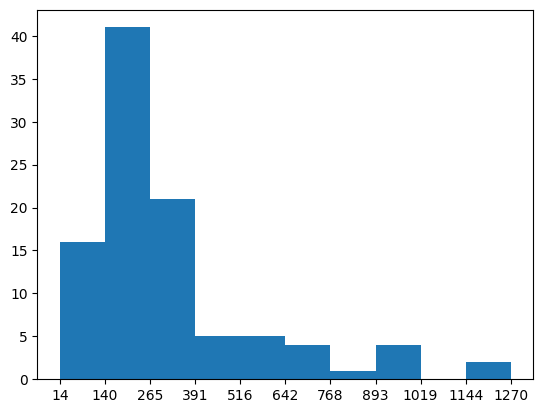

In [8]:
#Create a histogram (or density plot) of the inter-arrival times
plt.hist(customer_arrival_df['iat'])
plt.xticks(np.histogram_bin_edges(customer_arrival_df['iat']))
plt.show()

In [9]:
#Fit (and evaluate) the data to the potential distributions, use a significance level of 0.05

significance_level = 0.05

results = {}
for dist in list_of_potential_distributions:

    #fit the data to the distribution, and get the parameters, in this case we're using the maximum likelihood estimation (mle)
    dist_parameters = dist.fit(customer_arrival_df['iat'], method='mle')

    #evaluate with the kolmogorov-smirnov test
    test_result = stats.kstest(customer_arrival_df['iat'], dist.name, args=dist_parameters)

    #save the test results and the parameters
    results[dist.name] = {'test': test_result, 'params': dist_parameters}

    if test_result.pvalue < significance_level:
        print(f'{dist.name} is a "poor" fit, p-value: {test_result.pvalue}')
    else:
        print(f'{dist.name} is a "good" fit, p-value: {test_result.pvalue}')

expon is a "poor" fit, p-value: 0.0005171577217930409
norm is a "poor" fit, p-value: 1.828392457551867e-06
uniform is a "poor" fit, p-value: 7.576381300801526e-26
gamma is a "poor" fit, p-value: 0.010520881651178106


Answer the following questions:

- Is there any distribution that have a good fit to this dataset?

**Answer in this markdown chunk:**

- *No*

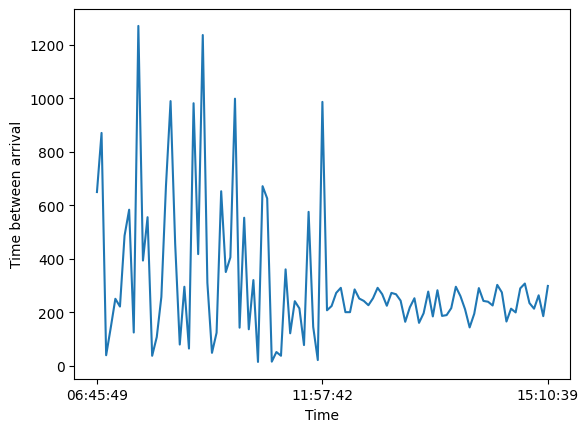

In [10]:
#Plot the iat column over time
import seaborn as sns
import pandas as pd

data = pd.DataFrame({'Time': customer_arrival_df['timestamp'], 'Time between arrival': customer_arrival_df['iat']})
sns.lineplot(x='Time', y='Time between arrival', data=data)
plt.xticks([0, 49, 98])
plt.show()


In [11]:
data = pd.DataFrame({'Time': customer_arrival_df['timestamp'], 'Time between arrival': customer_arrival_df['iat']})
print(data)

        Time  Time between arrival
1   06:45:49                 649.0
2   07:00:19                 870.0
3   07:00:58                  39.0
4   07:03:20                 142.0
5   07:07:30                 250.0
..       ...                   ...
95  14:54:40                 234.0
96  14:58:13                 213.0
97  15:02:36                 263.0
98  15:05:41                 185.0
99  15:10:39                 298.0

[99 rows x 2 columns]


Answer the following questions:

- Is there any particular pattern that you can see?

**Answer in this markdown chunk:**

- *At first the time between customer's arrival is more unpredictable and fluctuates a lot. We can see that the interval between arrival of customers in the morning is generaly bigger than during lunch time. During lunch hours customers arrive more frequently with the interval between their arrivals being from around 180s to 300s.*

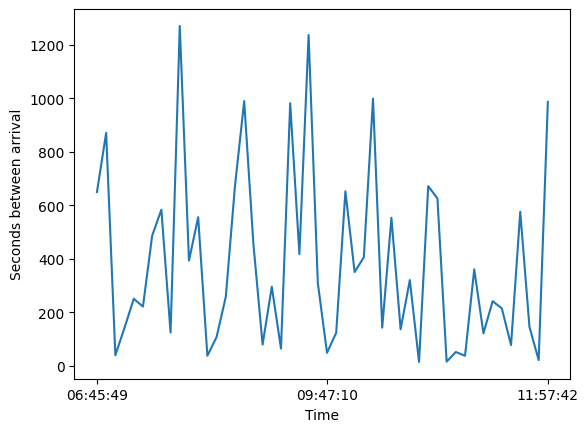

In [12]:
#Split the data into peak and non-peak hours
data_morning = customer_arrival_df.iloc[0:50]
#print(data_morning)

data_morning_1 = pd.DataFrame({'Time': data_morning['timestamp'], 'Seconds between arrival': data_morning['iat']})
sns.lineplot(x='Time', y='Seconds between arrival', data=data_morning_1)
plt.xticks([0, 25, 49])
plt.show()


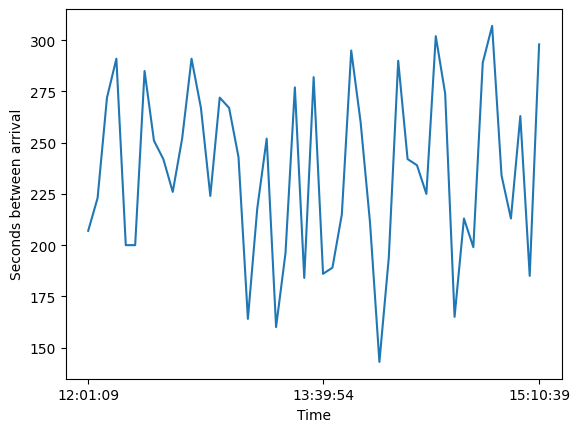

In [13]:
data_lunch = customer_arrival_df.iloc[50:100]
#print(data_lunch)

data_lunch_1 = pd.DataFrame({'Time': data_lunch['timestamp'], 'Seconds between arrival': data_lunch['iat']})
sns.lineplot(x='Time', y='Seconds between arrival', data=data_lunch_1)
plt.xticks([0, 25, 48])
plt.show()


#### Non peak demand

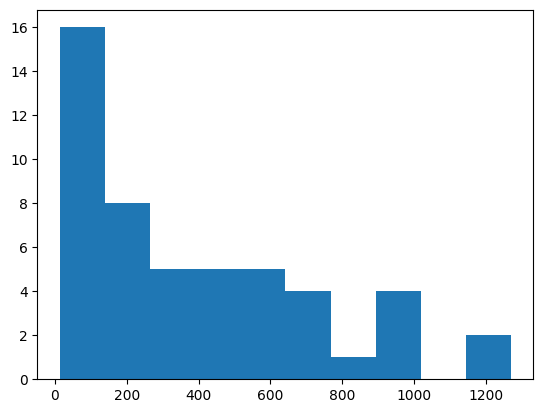

In [14]:
#Create a histogram (or density plot) of the inter-arrival times for non-peak period
plt.hist(data_morning['iat'])
plt.show()

In [15]:
#Fit (and evaluate) the data (non-peak) to the potential distributions, use a significance level of 0.05
significance_level = 0.05

results = {}
for dist in list_of_potential_distributions:

    #fit the data to the distribution, and get the parameters, in this case we're using the maximum likelihood estimation (mle)
    dist_parameters = dist.fit(data_morning['iat'], method='mle')

    #evaluate with the kolmogorov-smirnov test
    test_result = stats.kstest(data_morning['iat'], dist.name, args=dist_parameters)

    #save the test results and the parameters
    results[dist.name] = {'test': test_result, 'params': dist_parameters}

    if test_result.pvalue < significance_level:
        print(f'{dist.name} is a "poor" fit, p-value: {test_result.pvalue}')
    else:
        print(f'{dist.name} is a "good" fit, p-value: {test_result.pvalue}')


expon is a "good" fit, p-value: 0.8426029928614678
norm is a "good" fit, p-value: 0.22506228797852057
uniform is a "poor" fit, p-value: 1.5352248651984644e-05
gamma is a "good" fit, p-value: 0.3772176758897421


(14.0, 373.24)


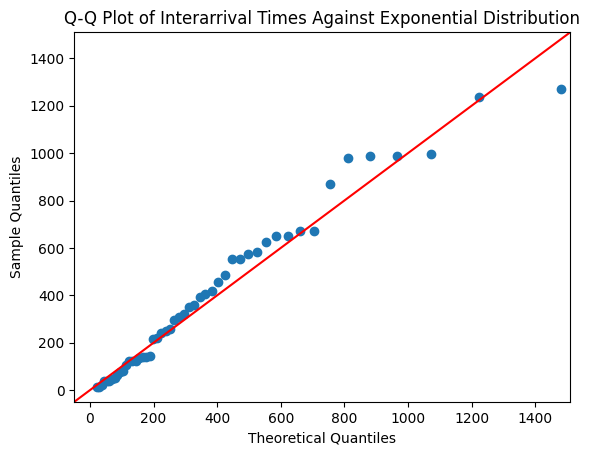

In [16]:
#Inspect visually the best fit distribution, use a qqplot
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
from scipy import stats

params = stats.expon.fit(data_morning['iat'])
print(params)
loc, scale = params

fig = sm.qqplot(data_morning['iat'], dist=stats.expon, line='45', loc=loc, scale=scale)

plt.title('Q-Q Plot of Interarrival Times Against Exponential Distribution')
plt.show()


#### Peak demand

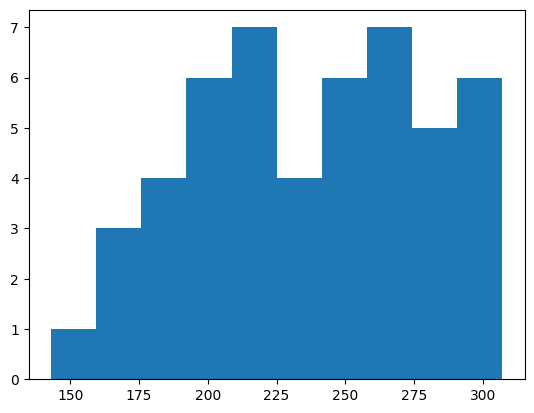

In [17]:
#Create a histogram (or density plot) of the inter-arrival times for peak period
plt.hist(data_lunch['iat'])
plt.show()

In [18]:
#Fit (and evaluate) the data (peak) to the potential distributions, use a significance level of 0.05
significance_level = 0.05

results = {}
for dist in list_of_potential_distributions:

    dist_parameters = dist.fit(data_lunch['iat'], method='mle')

    test_result = stats.kstest(data_lunch['iat'], dist.name, args=dist_parameters)

    results[dist.name] = {'test': test_result, 'params': dist_parameters}

    if test_result.pvalue < significance_level:
        print(f'{dist.name} is a "poor" fit, p-value: {test_result.pvalue}')
    else:
        print(f'{dist.name} is a "good" fit, p-value: {test_result.pvalue}')


expon is a "poor" fit, p-value: 0.0009602825336618714
norm is a "good" fit, p-value: 0.7715558501034626
uniform is a "good" fit, p-value: 0.1104710716109476
gamma is a "good" fit, p-value: 0.7625331553584792


(236.26530612244898, 42.531513171546)


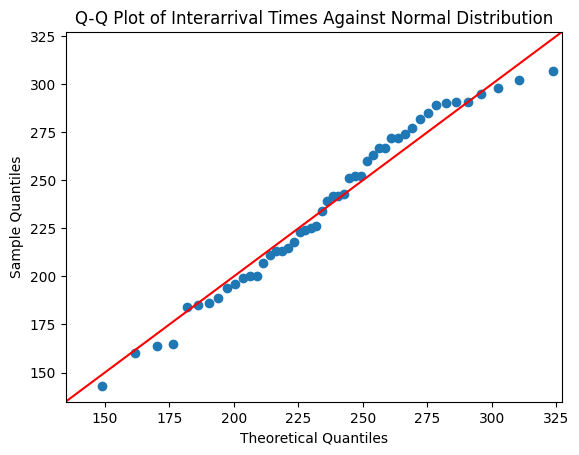

In [19]:
#Inspect visually the best fit distribution, use a qqplot
params = stats.norm.fit(data_lunch['iat'])
print(params)
loc, scale = params

fig = sm.qqplot(data_lunch['iat'], dist=stats.norm, line='45', loc=loc, scale=scale)

plt.title('Q-Q Plot of Interarrival Times Against Normal Distribution')
plt.show()

Answer the following questions:

1. Which distribution best fits to the non-peak demand period? What are the parameters of the distribution?
1. Which distribution best fits to the peak demand period? What are the parameters of the distribution?

**Answer in this markdown chunk:**

1. *The non-peak (morning data) is best described by exponential distribution. The parameters are (14.0, 373.24).*
1. *The peak (lunch data) is best described by normal distribution. The parameters are (236.3, 42.5).*

## Task 2:  Inverse Transform Method (Empirical CDF)

We'd like to sample using the empirical CDF of our customer arrival dataset. For that, we'll implement the Inverse Transform Method.

-----

**Task 2.1: Create a histogram (or a density plot) for the `iat` column of `customer_arrival_df` DataFrame.**

**Task 2.2: Count the number of ocurrences of the `iat` values in different intervals. This can be easily done with the `np.histogram()` function. Check the [documentation](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) to understand how it works. Note that the function return two values: `hist` and `bin_edges` and that the number of bins (intervals) is a parameter you've to choose.**

Using the above function we've created (for you) a DataFrame called `empirical_cdf_df` which have 3 columns: 
- `interval_lb`: the lower bound of the interval
- `interval_ub`: the upper bound of the interval
- `freq`: the number of ocurrences of `iat` values that are present in the interval (i.e. the frequency of observations)

With 8 intervals, the table should look like this:

<img src="images/assignment5_empirical_cdf.png" style="width:20%" />

This means that there are 23 observations of the `iat` values in the [14.0, 171.0] interval, 53 in [171.0, 328.0], and so on.

The DataFrame is still not entirely complete, we'd like to create a table that looks like this (from the lecture):

<img src="images/assignment5_empirical_cdf_lecture.png" style="width:50%" />

**Task 2.3: Create 3 more columns to `empirical_cdf_df`:**
- **`relative_freq`: relative frequency (i.e. frequency divided by the total number of observations)**
- **`cumulative_freq`: Cumulative sum of the relative frequency column. The last row of this column should be 1.0**
- **`slope`: The slope for the interval. This is defined as the upper bound minus the lower bound and this result divided by the probability of being in that interval. What is this probability?**

Now we have our Empirical CDF table ready to implement the Inverse Transform Method. Check the following example of how is computed using the table from the lecture:

<img src="images/assignment5_empirical_itm_lecture.png" style="width:50%" />

The procedure should receive a random number between 0 and 1 ($R=0.83$ in the example) and, using the Empirical CDF, return a (sampled) value ($X=1.75$ in the example).

**Task 2.4: Compute the following variables of the method:**
- **$i$: the index of the row where R falls. In the lecture example ($R=0.83$), $i=4$ (i.e. the 4th row). You may want to use the function `np.where` for this. Recall that indexes in python start at 0.**
- **$x$: the lower bound of the interval where R falls. In the lecture example ($R=0.83$), $x=1.5$.**
- **$a$: the slope of the interval where R falls. In the lecture example ($R=0.83$), $a=1.47$.**
- **$c$: the cumulative frequency of the previous interval where R falls. In the lecture example ($R=0.83$), $c=0.66$. Take special consideration in the case where $i=0$, what value should take this variable in this case?**
- **$X$: the resulting (sampled) value. In the lecture example ($R=0.83$), $X=1.75$**

**Task 2.5: Now that you have computed everything for one particular $R$, pack the implementation in a function: `inverse_transform_sampling`**

Finally, use the function `inverse_transform_sampling` for sampling from the Empirical CDF. Check how the (sampled) distribution looks like and compare it with the original histogram of Task 2.1 (we provide this last code for you, you don't have to code anything). 

If you want, check how the results change with different sample sizes and with different number of bins (for creating the Empirical CDF)

-----

**Hint: You may want to use the `.iloc[]` method for selecting rows by index in a DataFrame. For example, if you want to select the value of the column `c1` in the 5th row of a DataFrame, `df`, this is the syntax: `df.iloc[4]['c1']` (rembember, indexes start at 0 in python)**

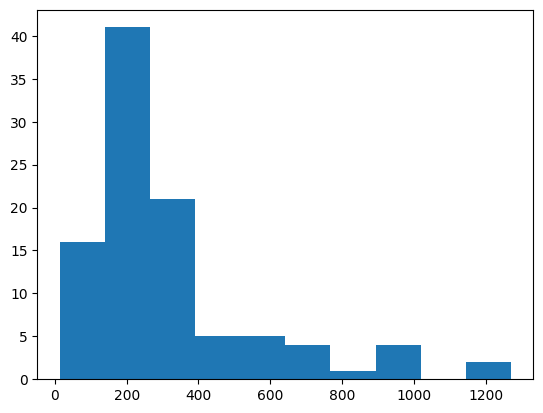

In [20]:
#Create a histogram (or density plot) of the inter-arrival times
histogram = plt.hist(customer_arrival_df['iat'])
plt.show()

In [21]:
#Count the number of ocurrences of the "iat" values in different intervals. Name this as hist, bin_edges

hist, bin_edges = np.histogram(customer_arrival_df['iat'], bins = 8)


In [22]:
empirical_cdf_df = pd.DataFrame({'interval_lb': bin_edges[:-1], #lower bound
                                 'interval_ub': bin_edges[1:], #upper bound
                                 'freq': hist}) #frequency of observations

empirical_cdf_df

,interval_lb,interval_ub,freq
0,14.0,171.0,23
1,171.0,328.0,53
2,328.0,485.0,6
3,485.0,642.0,6
4,642.0,799.0,4
5,799.0,956.0,1
6,956.0,1113.0,4
7,1113.0,1270.0,2


In [34]:
#Create 3 new columns: relative_freq, cumulative_freq, slope

relative_freq = []
for i in range(0, len(empirical_cdf_df['freq'])):
    sum_freq = sum(empirical_cdf_df['freq'])
    relative = empirical_cdf_df['freq'][i]/sum_freq
    relative_freq.append(relative)

cumilative_freq = []
for i in range(0, len(relative_freq)):
    suma = sum(relative_freq[:i])
    cumilative_freq.append(suma)

slope = []
for i in range(0, len(empirical_cdf_df)):
    lower_bound = empirical_cdf_df['interval_lb'][i]
    upper_bound = empirical_cdf_df['interval_ub'][i]
    probability = empirical_cdf_df['relative_freq'][i]
    slopee = (upper_bound - lower_bound) / probability
    slope.append(slopee)


empirical_cdf_df['relative_freq'] = relative_freq
empirical_cdf_df['cumulative_freq'] = cumilative_freq
empirical_cdf_df['slope'] = slope
print(empirical_cdf_df)

   interval_lb  interval_ub  freq  relative_freq  cumulative_freq  \
0         14.0        171.0    23       0.232323         0.000000   
1        171.0        328.0    53       0.535354         0.232323   
2        328.0        485.0     6       0.060606         0.767677   
3        485.0        642.0     6       0.060606         0.828283   
4        642.0        799.0     4       0.040404         0.888889   
5        799.0        956.0     1       0.010101         0.929293   
6        956.0       1113.0     4       0.040404         0.939394   
7       1113.0       1270.0     2       0.020202         0.979798   

          slope  
0    675.782609  
1    293.264151  
2   2590.500000  
3   2590.500000  
4   3885.750000  
5  15543.000000  
6   3885.750000  
7   7771.500000  


In [38]:
#Create 3 new columns: relative_freq, cumulative_freq, slope

# Create empirical_cdf_df DataFrame
empirical_cdf_df = pd.DataFrame({'interval_lb': bin_edges[:-1], 'interval_ub': bin_edges[1:], 'freq': hist})

# Compute relative frequency
empirical_cdf_df['relative_freq'] = empirical_cdf_df['freq'] / empirical_cdf_df['freq'].sum()

# Compute cumulative frequency
empirical_cdf_df['cumulative_freq'] = empirical_cdf_df['relative_freq'].cumsum()

# Compute slope
empirical_cdf_df['slope'] = (empirical_cdf_df['interval_ub'] - empirical_cdf_df['interval_lb']) / empirical_cdf_df['relative_freq']
print(empirical_cdf_df)


   interval_lb  interval_ub  freq  relative_freq  cumulative_freq  \
0         14.0        171.0    23       0.232323         0.232323   
1        171.0        328.0    53       0.535354         0.767677   
2        328.0        485.0     6       0.060606         0.828283   
3        485.0        642.0     6       0.060606         0.888889   
4        642.0        799.0     4       0.040404         0.929293   
5        799.0        956.0     1       0.010101         0.939394   
6        956.0       1113.0     4       0.040404         0.979798   
7       1113.0       1270.0     2       0.020202         1.000000   

          slope  
0    675.782609  
1    293.264151  
2   2590.500000  
3   2590.500000  
4   3885.750000  
5  15543.000000  
6   3885.750000  
7   7771.500000  


In [39]:
#Compute every variable of the method 

R = np.random.uniform(0, 1)
print(R)
print(f"R: {R}")

i = np.where(empirical_cdf_df['cumulative_freq'] >= R)[0][0]

print(f"i: {i}")

x = empirical_cdf_df.iloc[i]['interval_lb']

print(f"x: {x}")

a = empirical_cdf_df.iloc[i]['slope']

print(f"a: {a}")

c = 0 if i == 0 else empirical_cdf_df.iloc[i - 1]['cumulative_freq']

print(f"c: {c}")

X = x + (R - c) * a

print(f"X: {X}")

0.6262784738637577
R: 0.6262784738637577
i: 1
x: 171.0
a: 293.2641509433962
c: 0.23232323232323232
X: 286.53294942008273


Once we've implemented the method for one $R$, let's pack the implementation in a function:

In [40]:
#Complete the function that implements the inverse transform sampling method (with the code of the previous cell)

def inverse_transform_sampling(empirical_cdf_df):
    R = np.random.uniform(0, 1)
    
    i = np.where(empirical_cdf_df['cumulative_freq'] >= R)[0][0]
    
    x = empirical_cdf_df.iloc[i]['interval_lb']
    
    a = empirical_cdf_df.iloc[i]['slope']
    
    c = empirical_cdf_df.iloc[i-1]['cumulative_freq'] if i > 0 else 0
    
    X = x + (R - c) * a
    
    return X


Finally, we'll use the function for sampling from the Empirical CDF:

<Axes: ylabel='Count'>

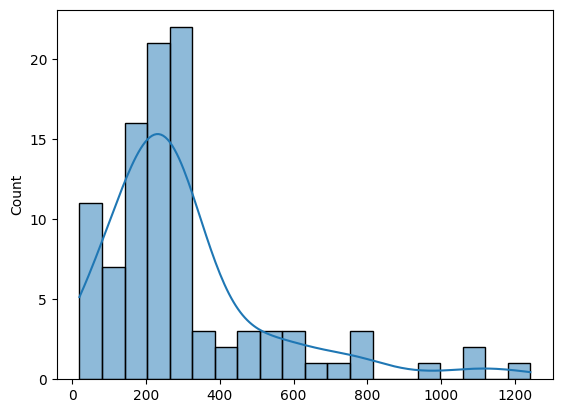

In [44]:
#Empirical CDF sampling

n_samples = 100
data = []

for i in range(n_samples):
    data.append(inverse_transform_sampling(empirical_cdf_df))

sns.histplot(data, kde=True)

## Task 3:  Final Project Description 

We'd like you start thinking of the final project. Therefore we ask you to answer the following questions:

1. What system would you like to analyze? Describe the system in terms of entity(ies), resource(s) and process(es) and how they interact with each other.
1. What (input) measurements do you need to calibrate the system? How would you collect them?
1. What (output) measurements do you need to validate the system? How would you collect them?
1. What output measurement(s) would you like to evaluate and optimize?

Is not mandatory but if you want you can support your description with a flow diagram.

**Answer in this markdown chunk:**

Our final project will be about a small pizza or kebab shop.

### 1. System Analysis

**Entities:**
- **Customers**: Customers who visit the pizza/kebab shop.
- **Staff**: Employees working in various roles such as cooks, servers, and cashiers.
- **Inventory**: Ingredients and supplies required to make pizza/kebab or drinks.
- **Equipment**: Ovens, cash registers.

**Resources:**
- **Time**: Operational hours, staff shifts, customer wait times.
- **Ingredients**: Dough, cheese, toppings, beverages, etc.
- **Financial**: Cash flow, cost of goods sold, employee wages.

**Processes:**
- **Order Taking**: Customers place orders at the counter or table.
- **Food/Drink Preparation**: Staff prepare the orders using the available inventory and equipment.
- **Service**: Orders are served to customers.
- **Payment**: Customers pay for their orders.

**Interactions:**
- **Customers** interact with **staff** to place orders and make payments.
- **Staff** interact with **equipment** to prepare food/drinks.
- **Inventory** is used by **staff** in the preparation process.
- **Financial resources** are managed based on sales and expenses.

### 2. Input Measurements for Calibration

- **Customer Arrival Rate**: Number of customers arriving per hour. Collected through manual counting or restaurant's system logs.
- **Order Types and Frequencies**: Types of orders (e.g., different types of pizzas, kebab, drinks) and their frequencies. Taken from the menue and restaurant's log.
- **Preparation Times**: Time taken to prepare different types of orders. Based on the kitchens experience.
- **Service Times**: Time taken to serve the order to the customer.
- **Inventory Levels**: Initial inventory levels and usage rates. Recorded manually or through inventory management software.
- **Staff Shifts and Availability**: Working hours and roles of staff. Collected from staff schedules.

### 3. Output Measurements for Validation

- **Customer Wait Time**: Time from placing the order to receiving it. 
- **Sales Data**: Daily/weekly sales figures. Collected from the restaurant's system.
- **Inventory Usage Rates**: Rates at which inventory items are used up.
- **Customer Satisfaction**: Overall satisfaction ratings from customers. Collected through Google reviews or other platforms.

### 4. Output Measurements for Evaluation and Optimization

- **Customer Wait Time**: Aim to minimize the wait time for better customer satisfaction.
- **Order Throughput**: Number of orders processed per hour. Aim to maximize without compromising quality.
- **Revenue**: Total sales revenue. Aim to maximize revenue while managing costs.
- **Labor Efficiency**: Productivity of staff. Aim to optimize staff allocation.
- **Inventory Turnover**: Frequency of inventory usage. Aim to balance stock levels to avoid shortages or overstocking.
